# Clinical Trial Analysis

### Disease Phenotype:

- Increase in Left Ventrical Size 
-- measured by left ventricular end-diastolic dimension (LVEDD)
- Elevated Heart Rate
- Reduced Ejection Fraction (EF)

### Experimental Design:

- 4 week clincal trial
- 20 patients (50/50 Placebo/Treatment)
- Measurements taken before the trial (pretreatment), 2 weeks in (2 weeks), 4 weeks in (4 weeks), and a 18 month follow up.

### Measurements 

- Heart Rate
- LVEDD
- Ejection Fraction -- Surogate Marker 
- Minnesota Living with Heart Failure Questionnaire (MLHFQ) -- Quality of Life

### Primary Endpoints 

- Survival Rate (18M)
- Decrease in LVEDD
- Increase in Ejection Fraction

### Summary:

##### This project aims to evaluate the clinical efficacy of a hypothetical therapeutic agent against an undisclosed cardiovascular disease using dilated cardiomyopathy as a model disease. The analysis is based on a randomized double-blind placebo-controlled study conducted on 20 patients, with an equal distribution of patients between the placebo and treatment groups. The main objective is to determine whether the therapeutic agent significantly increases the survival rate of the patients in the treatment group compared to those in the placebo group. Given the short time course of the trial an 18-month follow-up was incorporated into the study to measure 18-month survival. In addition, ejection fraction (EF) is included as a surrogate marker for success. A secondary goal of the project is to assess whether the combination of EF, heart rate, and measurements can predict 18-month survival with reasonable accuracy. Finally, the Minnesota Living with Heart Failure Questionnaire (MLHFQ) is utilized to determine whether the treatment affects the quality of life of the patients. In the preprocessing stage, the data was analyzed, and the columns were renamed to facilitate the analysis. The left ventricular (LV) size was adjusted for sex, BMI, and age using a multilinear regression model, with coefficients applied to each patient. Finally, columns related to BMI, age, sex, and unadjusted LV were removed to focus on relevant variables.

## Preprocessing

##### During the data preprocessing stage of this project, an analysis of the dataset was performed. This analysis included the renaming of columns to ensure a clear and concise labeling system. Furthermore, LV size measurements were adjusted for sex, BMI, and age, as it has been shown that these factors can influence heart size. To accomplish this, a multilinear regression model was used to generate coefficients, which were applied to each patient's LV size measurements. Following this adjustment, columns containing the variables of BMI, age, and sex, as well as the unadjusted LV size columns, were removed from the dataset. 

-Details can be seen in the file "RegPreProcessing.ipynb" in this repository.

##### Load in data and define functions

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import scikit_posthocs as sp
import matplotlib.gridspec as gridspec
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression


In [2]:
df = pd.read_csv('data/vis_data.csv')
df.head(2)

,PatientID,Treatment,HRPre,HR2W,HR4W,HR18M,mortality _treatement_period,Mortality18M,EFPre,EF2W,EF4W,EF18M,QoLPre,QoL2W,QoL4W,QoL18M,AdjPreLVSize,AdjLVSize2W,AdjLVSize4W,AdjLVSize18M
0,1,0,82.0,85.0,89.0,Dead,1.0,0.0,0.25,0.25,0.24,Dead,72.0,69.0,68.0,Dead,7.1,7.0,7.2,7.1
1,2,0,89.0,87.0,61.0,Dead,1.0,0.0,0.27,0.28,0.27,Dead,51.0,55.0,56.0,Dead,7.1,7.2,6.9,7.0


In [3]:
def boxplot_with_significance_plot(x, y, data, val_col, p_adjust='holm'):

    """
    Generates a box plot to visualize the distribution of a variable, and a significance plot to show the results of statistical tests of pairwise comparisons between groups.

    Args:
        x (str): The column name for the x-axis variable.
        y (str): The column name for the y-axis variable.
        data (pandas DataFrame): The input data.
        val_col (str): The column name for the variable to be tested.
        p_adjust (str): The method used for p-value adjustment.

    Returns:

    Boxplot paired with a significance plot.

    The box plot shows the median, interquartile range, and distribution of data points for each group. The significance plot shows color-coded squares that represent the results of the statistical tests.

    Red squares indicate that there is a significant difference between the corresponding groups. The intensity of the red color indicates the strength of the difference. Blue squares indicate that there is no significant difference between the corresponding groups.

    The Conover-Iman post hoc test is used to perform pairwise comparisons between groups and adjust the p-values using the Holm method. The resulting p-values are used to generate the color-coded squares in the significance plot, which indicate the results of the statistical tests. Together, these plots allow us to easily see if there are significant differences between groups and to identify which groups differ from each other.
    """

    data['Treatment'] = data['Treatment'].replace({0: 'Placebo', 1: 'Treatment'})
    post_hoc = sp.posthoc_conover(data, val_col=val_col, group_col='Treatment', p_adjust=p_adjust)

    plt.figure(figsize=(12, 6), dpi=80)
    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])

    # boxplot
    ax0 = plt.subplot(gs[0])
    ax0 = sns.boxplot(x=x, y=y, data=data, showfliers=False, width=0.5, palette='pastel', )
    ax0 = sns.swarmplot(x=x, y=y, data=data, color=".25")
    plt.yticks(fontsize=14)
    plt.xticks(fontsize=14)
    plt.xlabel(x, fontsize=14)
    plt.ylabel(y, fontsize=14)
    plt.title(f'Distribution of {y} by {x}', fontsize=14)

    # significance plot
    ax1 = plt.subplot(gs[1])

    heatmap_args = {'cmap': ['1', '#fb6a4a',  '#08306b',  '#4292c6', '#c6dbef'], 
                    'linewidths': 0.25, 
                    'linecolor': '0.5', 
                    'clip_on': False, 
                    'square': True, 
                    'cbar_ax_bbox': [1, 0.35, 0.04, 0.3],
                   }

    _ = sp.sign_plot(post_hoc, **heatmap_args)

    ax1.set_title('Significance plot', fontsize=14)
    ax1.set_yticklabels(ax0.get_xticklabels(), rotation=0, fontsize=12)
    ax1.set_xticklabels(ax0.get_xticklabels(), rotation=0, fontsize=12)
    plt.tight_layout()
    plt.show()

In [4]:
def plot_measurements_over_time(df, columns, treatment_column='Treatment', treatment_labels=['Placebo', 'Treatment']):

    """
    A function that plots the average measurement over time for two treatment groups in a clinical trial.

    Parameters:

    df: pandas DataFrame containing the trial data
    columns: a list of column names for the measurements to be plotted, with the first column being the primary measurement
    treatment_column: the name of the column indicating the treatment group
    treatment_labels: a list of labels for the treatment groups
    Returns:

    A line plot showing the average measurement over time for each treatment group, with shaded regions indicating the standard deviation of the measurements at each time point.
    T-test results for the second and third measurement time points between the two treatment groups.
    """

    # Calculate the average measurement for each treatment group and measurement time
    measurement_df = df.groupby([treatment_column]).agg({
        columns[0]: 'mean',
        columns[1]: 'mean',
        columns[2]: 'mean'
    }).reset_index()

    measurement_df[treatment_column] = measurement_df[treatment_column].replace({0: treatment_labels[0], 1: treatment_labels[1]})

    # Display the new dataframe
    print(measurement_df)

    # Perform a t-test on the second measurement time
    t_stat, p_value = stats.ttest_ind(df[(df[treatment_column] == 0)][columns[1]], df[(df[treatment_column] == 1)][columns[1]])
    print(f"{columns[1]} t-statistic: {round(t_stat, 3)}, p-value: {round(p_value, 5)}")

    # Perform a t-test on the third measurement time
    t_stat, p_value = stats.ttest_ind(df[(df[treatment_column] == 0)][columns[2]], df[(df[treatment_column] == 1)][columns[2]])
    print(f"{columns[2]} t-statistic: {round(t_stat, 3)}, p-value: {round(p_value, 5)}")

    # Melt the dataframe to create a "long" format for seaborn
    measurement_melted = measurement_df.melt(id_vars=treatment_column, var_name='Time', value_name='Measurement')

    # create the plot
    sns.set_style('darkgrid')
    sns.set_palette('pastel')
    fig, ax = plt.subplots(figsize=(9, 6))
    sns.lineplot(data=measurement_melted, x='Time', y='Measurement', hue=treatment_column, marker='o', ax=ax)

    # set the title font size
    ax.set_title(f'Average {columns[0]} Over Time by Treatment Group', fontsize=18, fontweight='bold', pad=20)

    # set the x and y axis labels and font size
    ax.set_xlabel('Measurement Time', fontsize=14, fontweight='bold', labelpad=15)
    ax.set_ylabel(columns[0], fontsize=14, fontweight='bold', labelpad=15)

    # set the legend title and font size
    ax.legend(title=treatment_column, fontsize=12)

    # set the tick label font size
    ax.tick_params(axis='both', which='major', labelsize=12)

    plt.show()

## Symptom Analysis



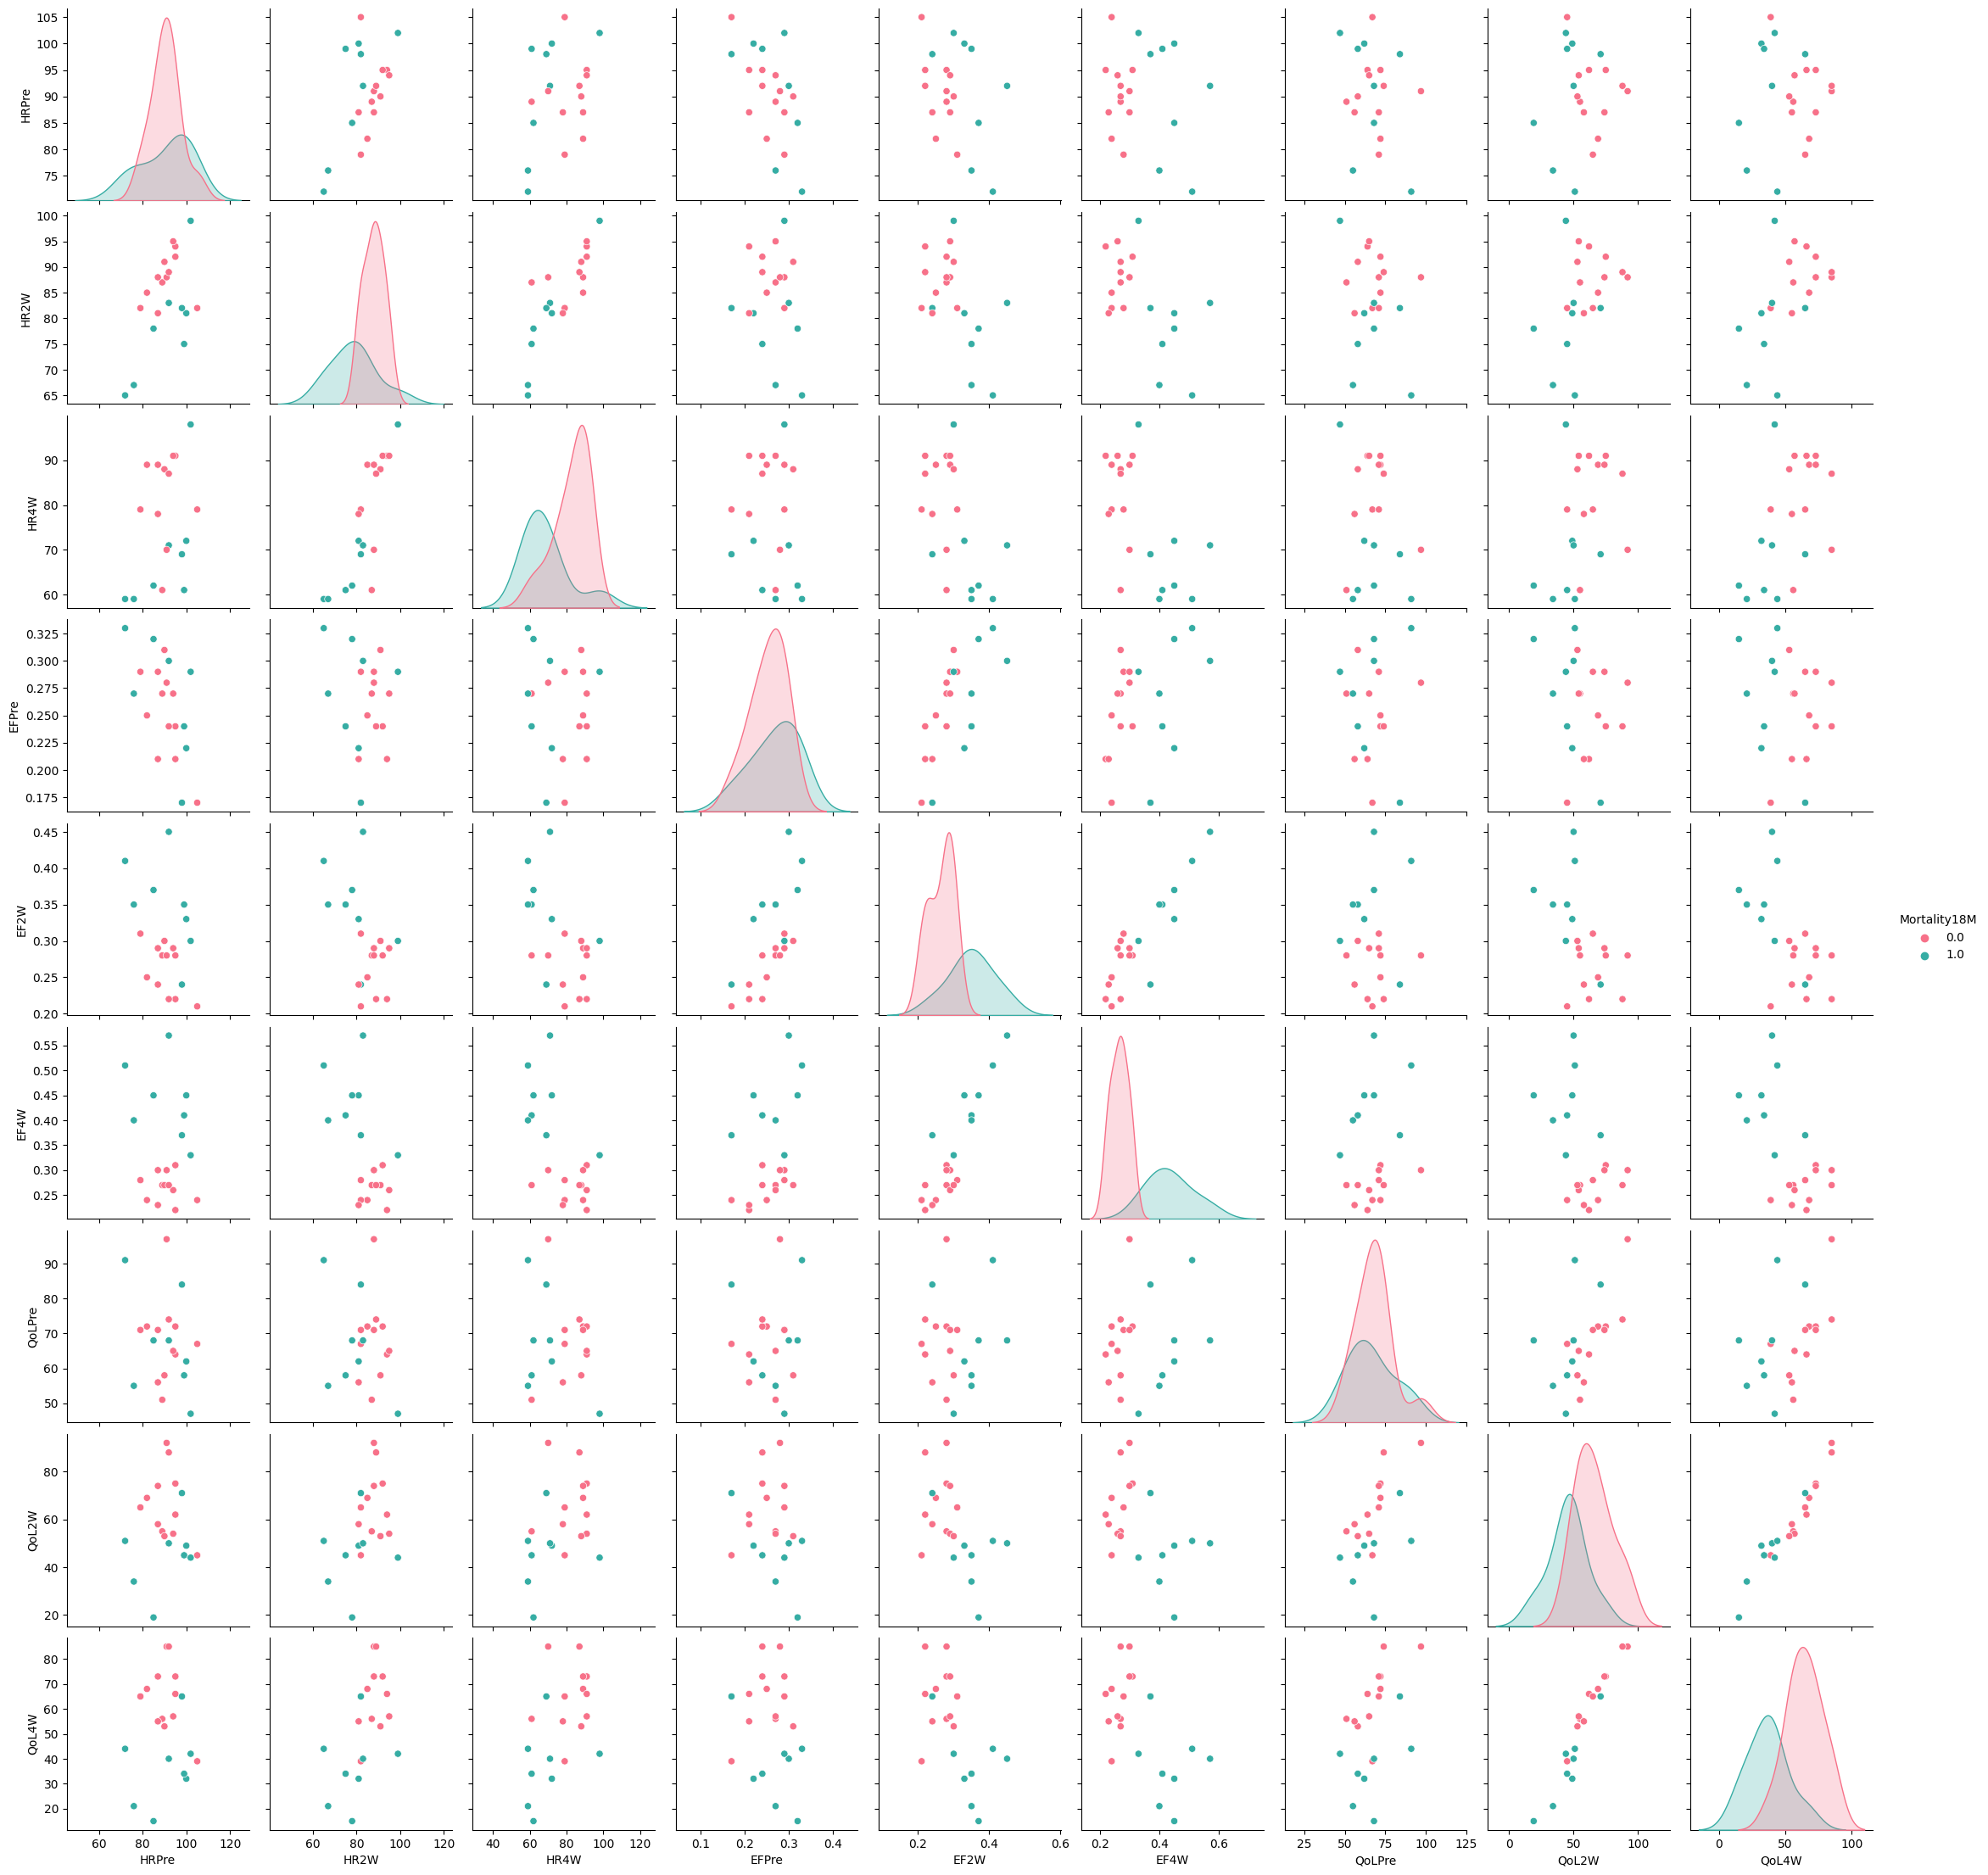

In [5]:
# Select the variables of interest
cols = ['HRPre', 'HR2W', 'HR4W', 'EFPre', 'EF2W', 'EF4W', 'QoLPre', 'QoL2W', 'QoL4W', 'Mortality18M']

# Create the pairplot using Seaborn's pairplot function
sns.pairplot(df[cols], hue='Mortality18M', palette='husl')

# Show the plot
plt.show()

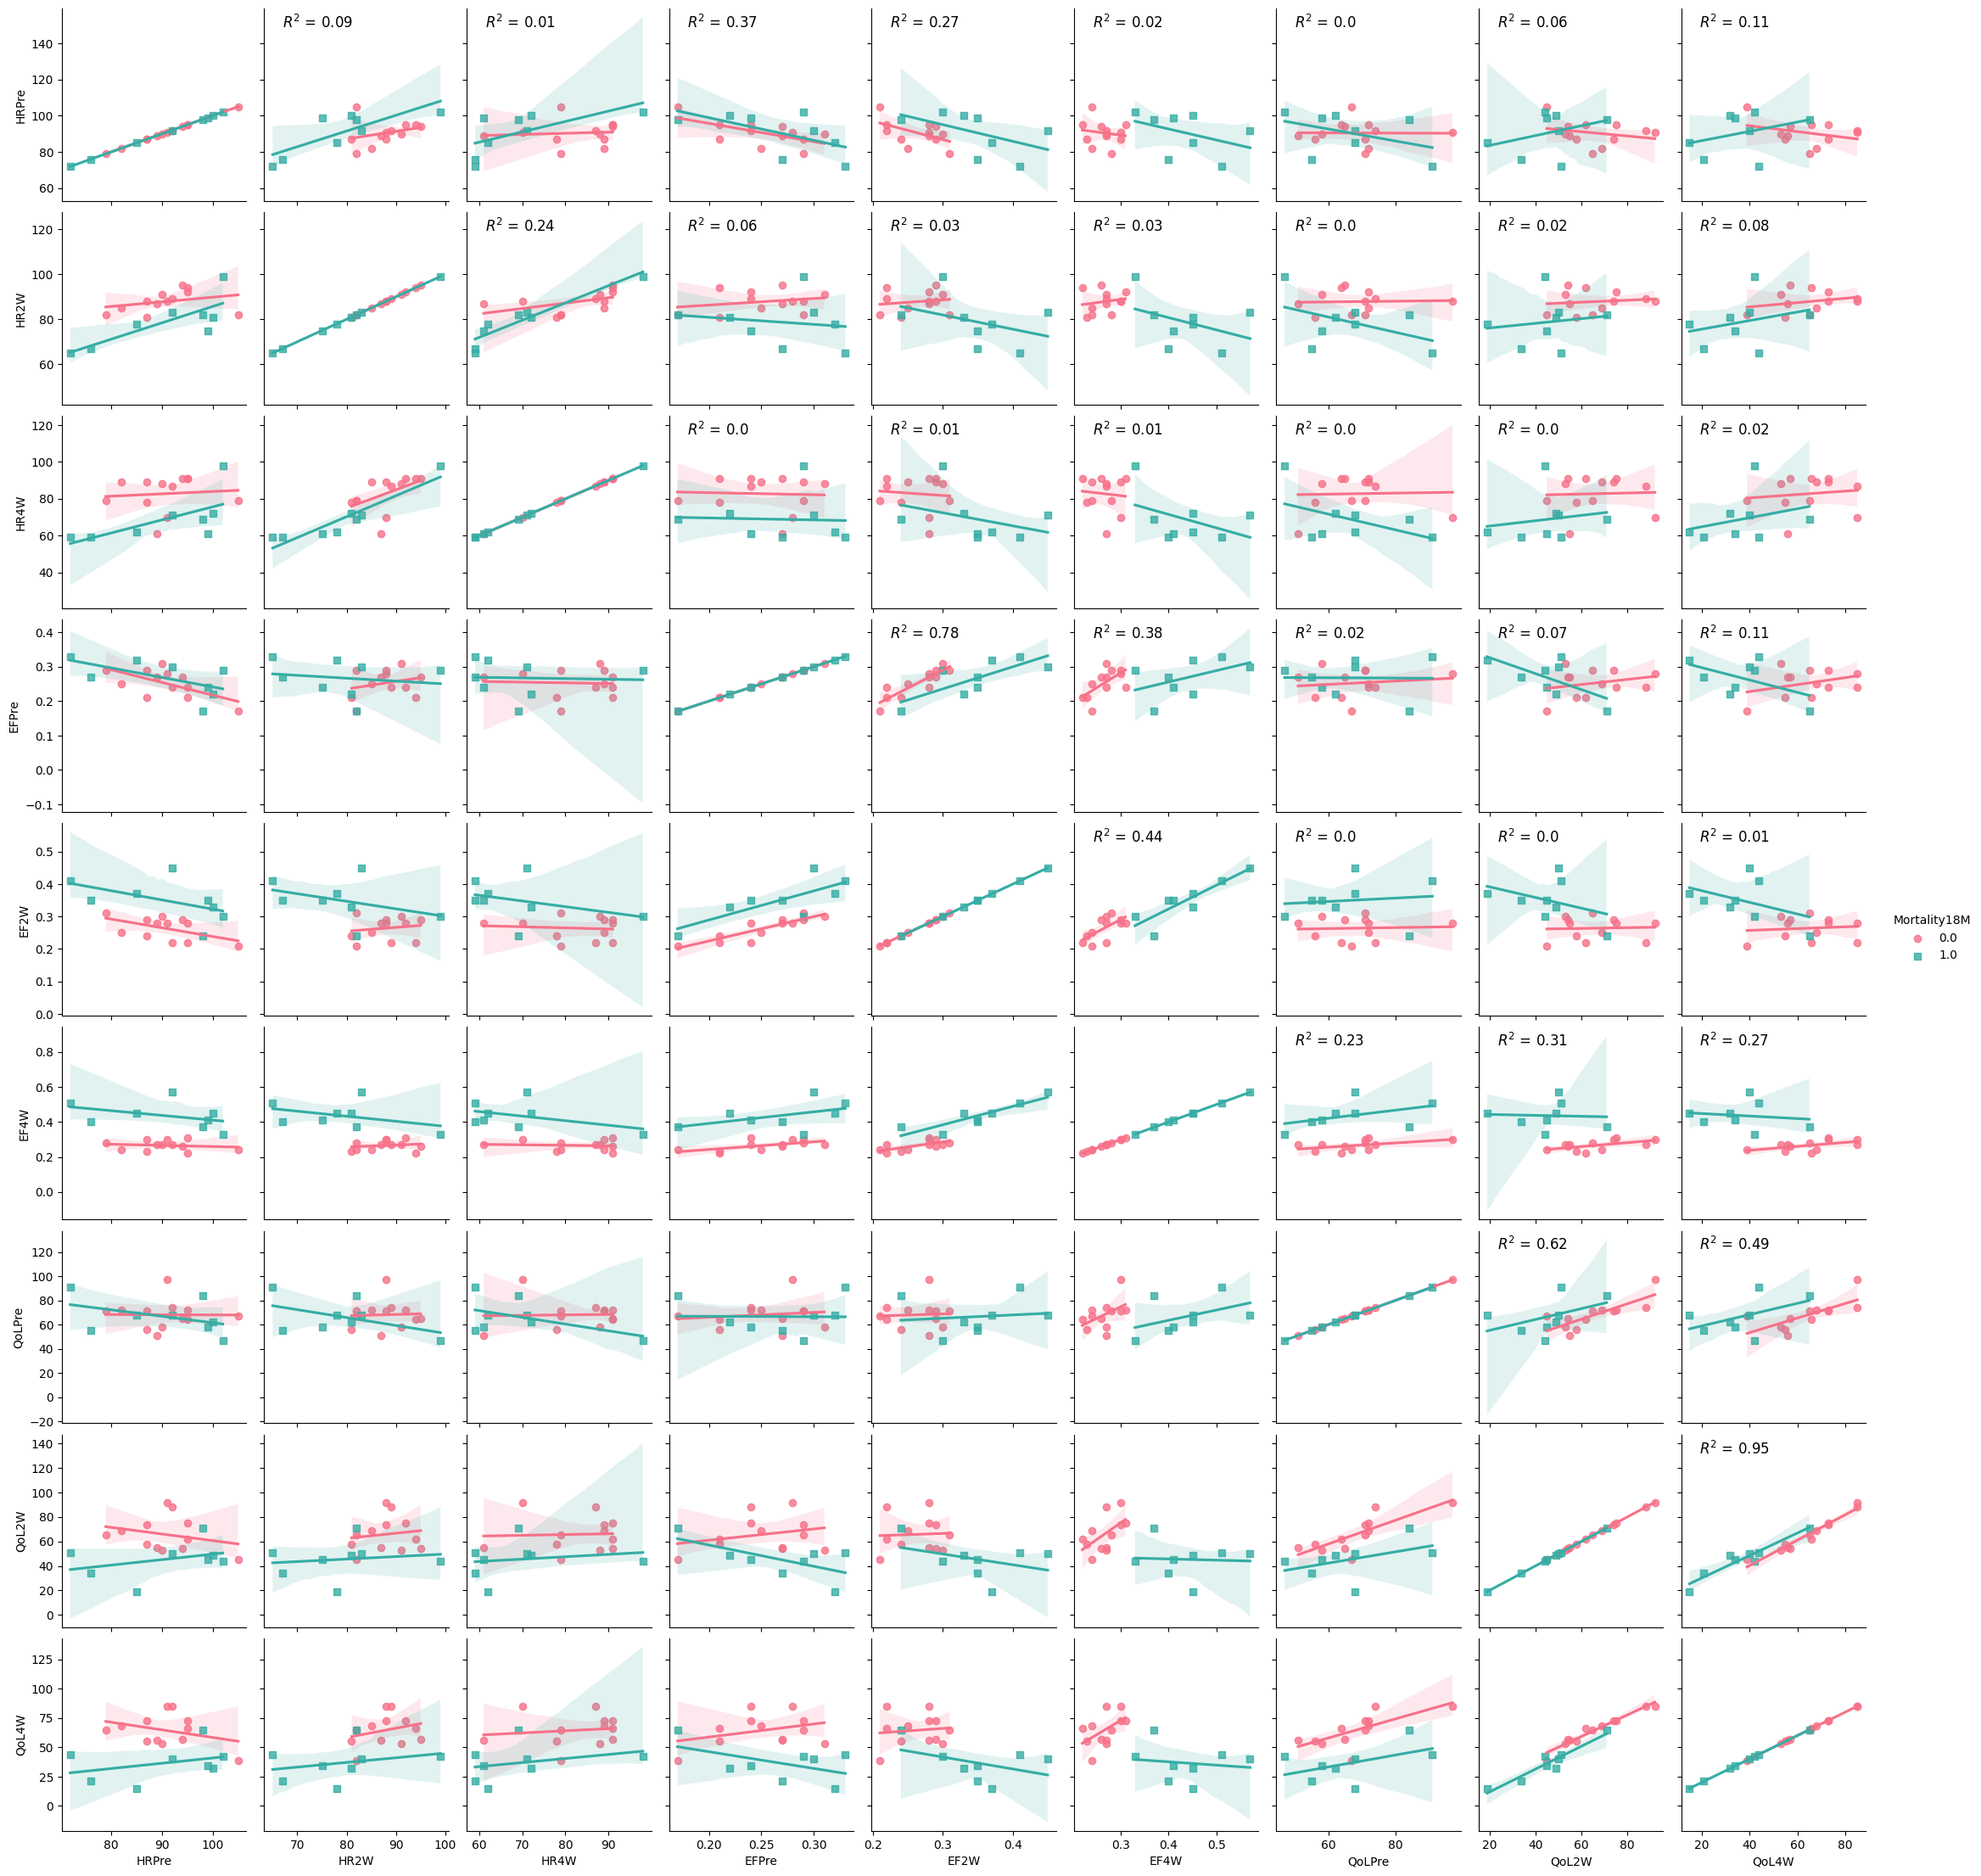

In [6]:
# Select the variables of interest
cols = ['HRPre', 'HR2W', 'HR4W', 'EFPre', 'EF2W', 'EF4W', 'QoLPre', 'QoL2W', 'QoL4W', 'Mortality18M']

# Create the pairplot using Seaborn's pairplot function
pair_grid = sns.pairplot(df[cols], hue='Mortality18M', palette='husl', markers=["o", "s"], diag_kind=None, kind="reg")

# Add R-squared value to each scatter plot
for i, j in zip(*np.triu_indices_from(pair_grid.axes, 1)):
    ax = pair_grid.axes[i, j]
    x = ax.collections[0].get_offsets()[:, 0]
    y = ax.collections[0].get_offsets()[:, 1]
    r, p = pearsonr(x, y)
    r_squared = round(r ** 2, 2)
    ax.annotate(f"$R^2$ = {r_squared}", xy=(.1, .9), xycoords=ax.transAxes, fontsize=12)

# Show the plot
plt.show()


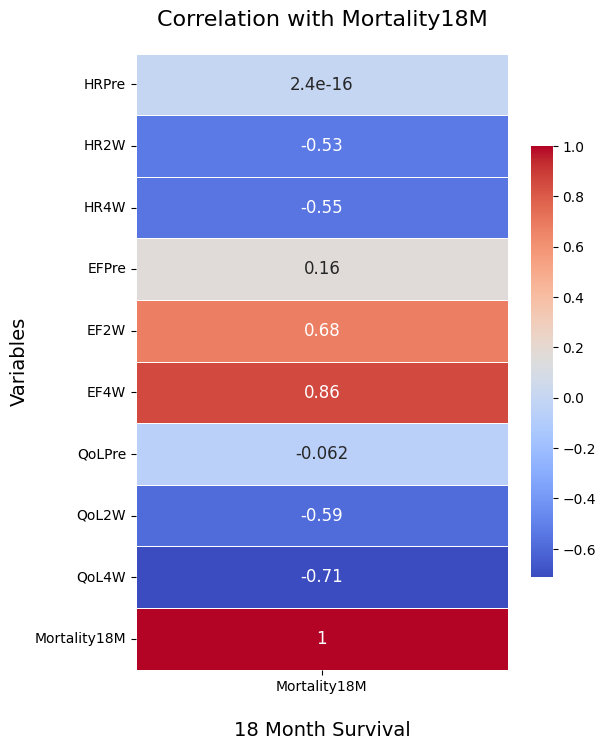

In [7]:
# Create a correlation matrix between Mortality18M and other variables
corr_matrix = df[cols].corr()[['Mortality18M']]

# Create the heatmap using Seaborn's heatmap function
plt.figure(figsize=(6, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=.5, cbar_kws={"shrink": .7}, annot_kws={"size": 12})

# Customize the plot
plt.title("Correlation with Mortality18M", fontsize=16, pad=20)
plt.xlabel("18 Month Survival", fontsize=14, labelpad=20)
plt.ylabel("Variables", fontsize=14)

# Show the plot
plt.show()


### Heart Rate

##### Heart rate is considered a crucial metric for evaluating the efficacy of the treatment, as it can provide important insights into the impact of the therapeutic agent on the cardiovascular system. Specifically, a reduction in heart rate following the initiation of treatment is often considered an indication of a positive response to the therapy, and it is typically expected to occur early in the treatment course, often within the first week or two of treatment. By tracking heart rate over time, clinicians can monitor the response to treatment and make adjustments as needed to optimize patient outcomes.

In [8]:
df_box = df

/var/folders/qm/qx46fb850rlbh6q98fgw87lw0000gn/T/ipykernel_54170/62544634.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


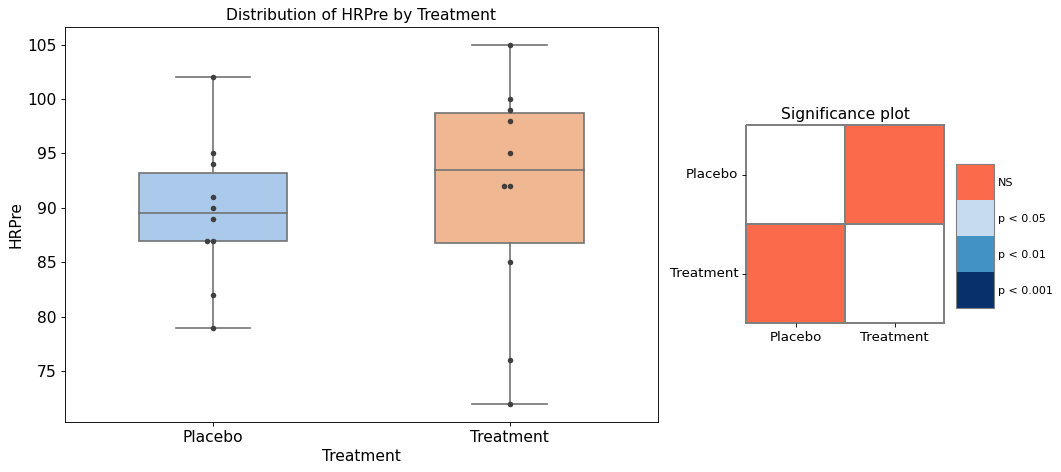

In [9]:
boxplot_with_significance_plot('Treatment', 'HRPre', df_box, 'HRPre', p_adjust='holm')

2 weeks

/var/folders/qm/qx46fb850rlbh6q98fgw87lw0000gn/T/ipykernel_54170/62544634.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


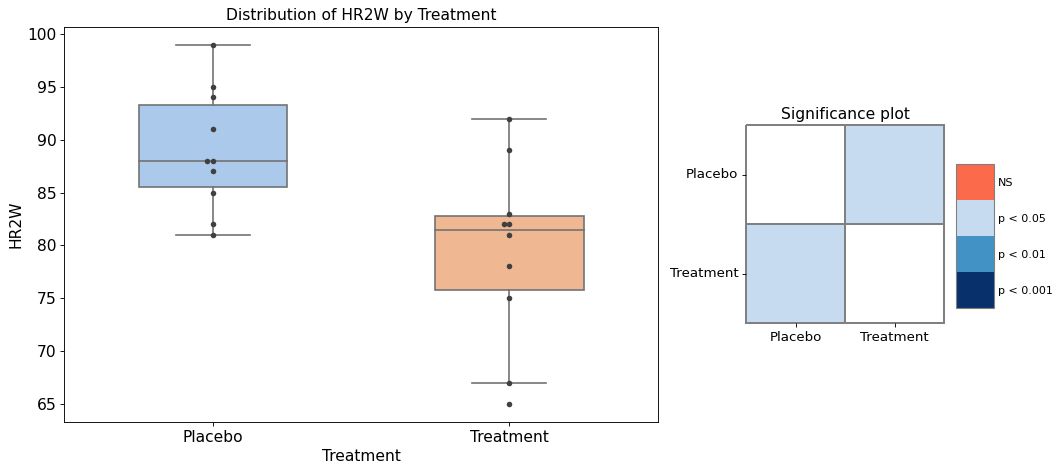

In [10]:
boxplot_with_significance_plot('Treatment', 'HR2W', df_box, 'HR2W', p_adjust='holm')

/var/folders/qm/qx46fb850rlbh6q98fgw87lw0000gn/T/ipykernel_54170/62544634.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


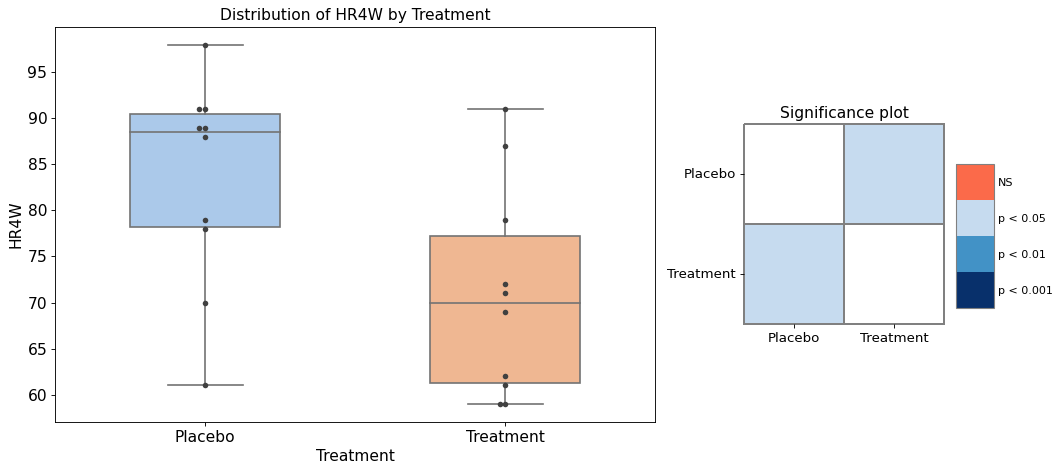

In [11]:
boxplot_with_significance_plot('Treatment', 'HR4W', df_box, 'HR4W', p_adjust='holm')

In [12]:
df = pd.read_csv('data/vis_data.csv')

   Treatment  HRPre  HR2W  HR4W
0    Placebo   89.6  89.0  83.4
1  Treatment   91.4  79.4  71.0
HR2W t-statistic: 2.936, p-value: 0.00884
HR4W t-statistic: 2.434, p-value: 0.02559


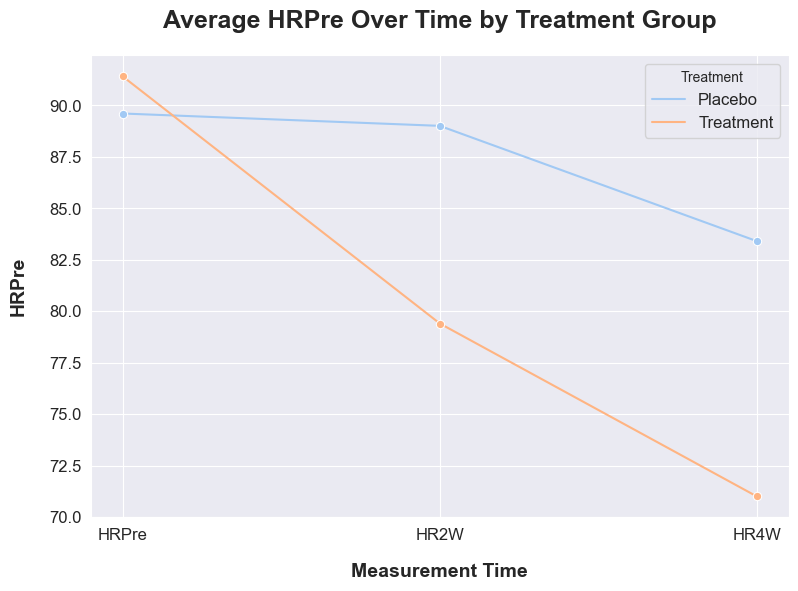

In [13]:
plot_measurements_over_time(df, ['HRPre', 'HR2W', 'HR4W'])

### Note the y-label and title of this are listed as average pretreatment measurment. It is supposed to read 'Average AdjLVSize'. This is a bug that resulted from me turning the original code into a callable function and needs debugging.

## Adjusted LV Measure

#### Left ventricular (LV) size is another crucial metric that is closely monitored in the evaluation of the therapeutic agent, as it is a strong predictor of survival and can provide important insights into the impact of the treatment on cardiac function. Specifically, a reduction in LV size is often considered a positive indication of response to therapy, and is expected to correlate strongly with improved survival rates. By tracking LV size over time, healthcare providers can gain important insights into the response to treatment and assess the effectiveness of the therapeutic agent in optimizing patient outcomes.

In [14]:
df.columns

Index(['PatientID', 'Treatment', 'HRPre', 'HR2W', 'HR4W', 'HR18M',
       'mortality _treatement_period', 'Mortality18M', 'EFPre', 'EF2W', 'EF4W',
       'EF18M', 'QoLPre', 'QoL2W', 'QoL4W', 'QoL18M', 'AdjPreLVSize',
       'AdjLVSize2W', 'AdjLVSize4W', 'AdjLVSize18M'],
      dtype='object')

/var/folders/qm/qx46fb850rlbh6q98fgw87lw0000gn/T/ipykernel_54170/62544634.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


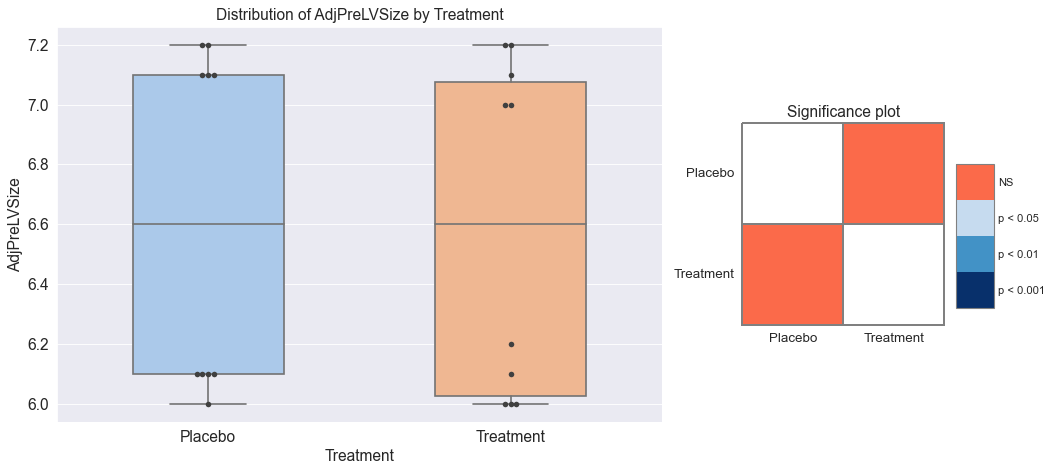

In [15]:
boxplot_with_significance_plot('Treatment', 'AdjPreLVSize', df_box, 'AdjPreLVSize', p_adjust='holm')

/var/folders/qm/qx46fb850rlbh6q98fgw87lw0000gn/T/ipykernel_54170/62544634.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


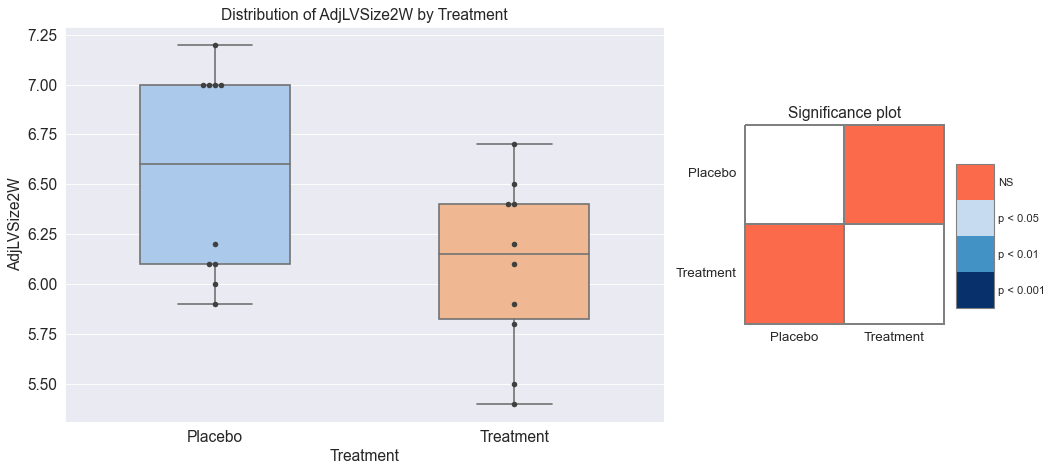

In [16]:
boxplot_with_significance_plot('Treatment', 'AdjLVSize2W', df_box, 'AdjLVSize2W', p_adjust='holm')

/var/folders/qm/qx46fb850rlbh6q98fgw87lw0000gn/T/ipykernel_54170/62544634.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


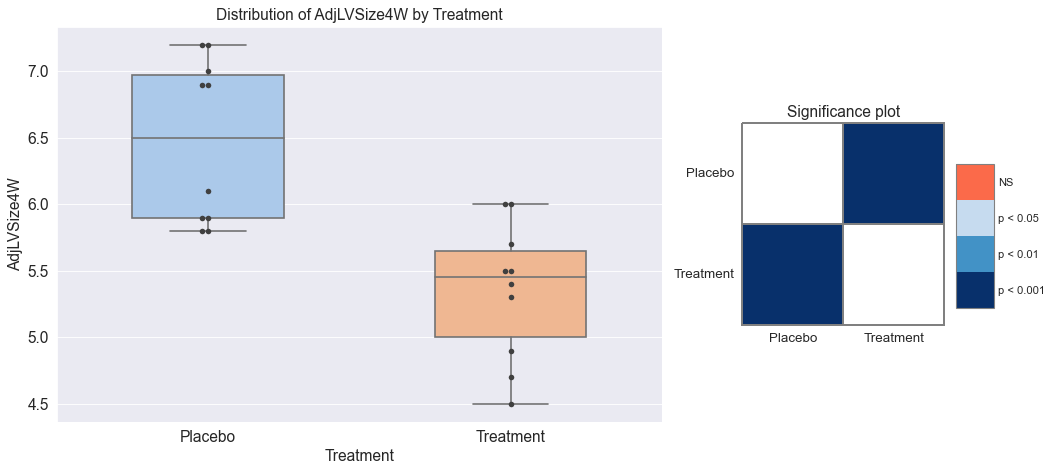

In [17]:
boxplot_with_significance_plot('Treatment', 'AdjLVSize4W', df_box, 'AdjLVSize4W', p_adjust='holm')

   Treatment  AdjPreLVSize  AdjLVSize2W  AdjLVSize4W
0    Placebo          6.61         6.55         6.47
1  Treatment          6.58         6.09         5.35
AdjLVSize2W t-statistic: 2.136, p-value: 0.04667
AdjLVSize4W t-statistic: 4.425, p-value: 0.00033


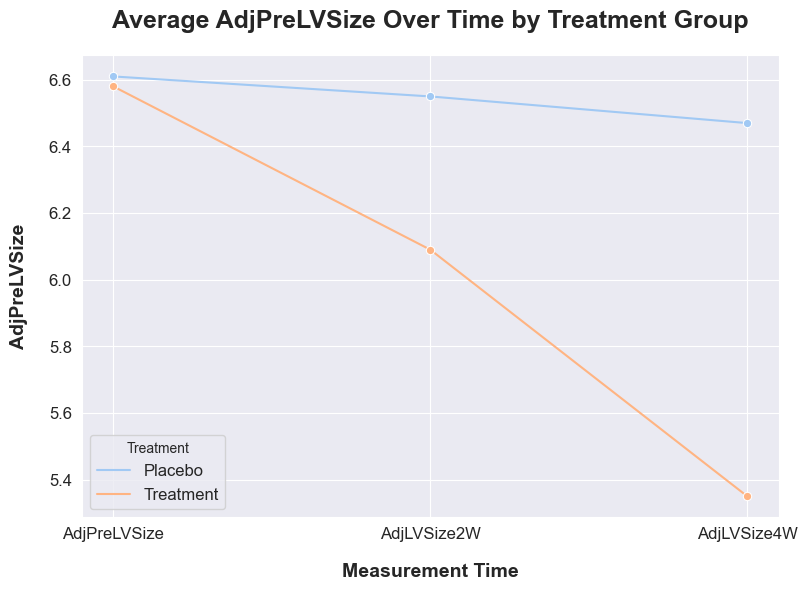

In [18]:
plot_measurements_over_time(df, ['AdjPreLVSize', 'AdjLVSize2W', 'AdjLVSize4W'])

### Note the y-label and title of this are listed as average pretreatment measurment. It is supposed to read 'Average AdjLVSize'. This is a bug that resulted from me turning the original code into a callable function and needs debugging.

## Ejection Fraction

#### Ejection fraction (EF) is another key metric that is frequently used as a surrogate marker for survival in the evaluation of the therapeutic agent. EF is a measure of the heart's pumping ability and provides important information about cardiac function. A reduction in EF is associated with an increased risk of adverse outcomes, including mortality. As such, EF is often closely monitored in patients with cardiovascular disease and is used as a key endpoint in clinical trials. By tracking EF over time, healthcare providers can assess the effectiveness of the therapeutic agent in improving cardiac function and reducing the risk of adverse outcomes.

/var/folders/qm/qx46fb850rlbh6q98fgw87lw0000gn/T/ipykernel_54170/62544634.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


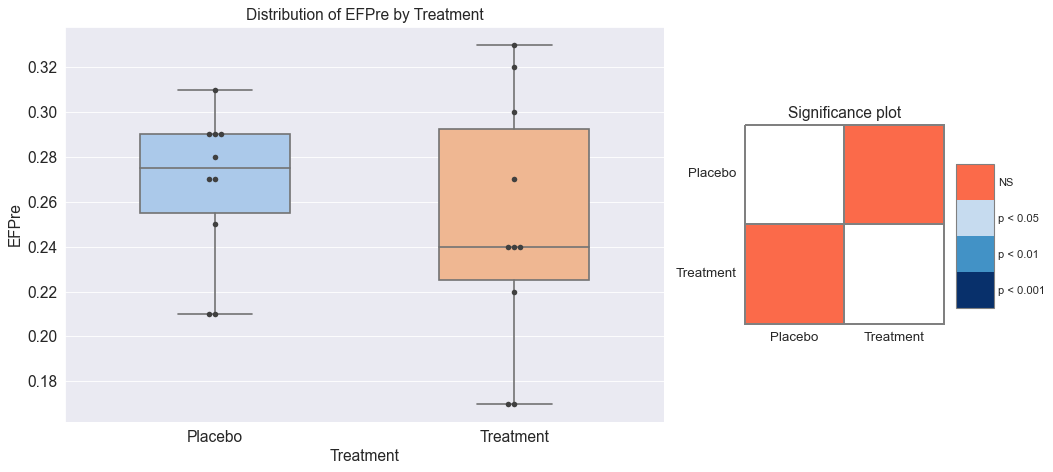

In [19]:
boxplot_with_significance_plot('Treatment', 'EFPre', df_box, 'EFPre', p_adjust='holm')

/var/folders/qm/qx46fb850rlbh6q98fgw87lw0000gn/T/ipykernel_54170/62544634.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


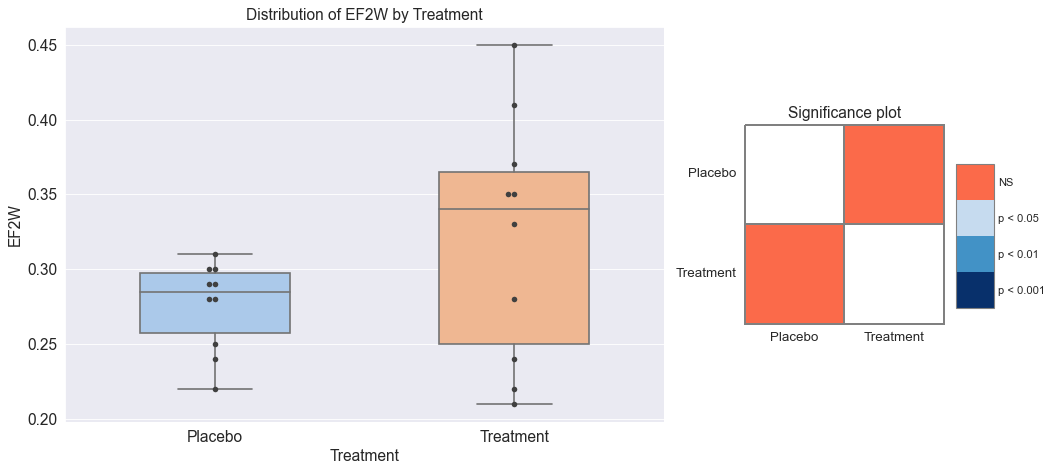

In [20]:
boxplot_with_significance_plot('Treatment', 'EF2W', df_box, 'EF2W', p_adjust='holm')

/var/folders/qm/qx46fb850rlbh6q98fgw87lw0000gn/T/ipykernel_54170/62544634.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


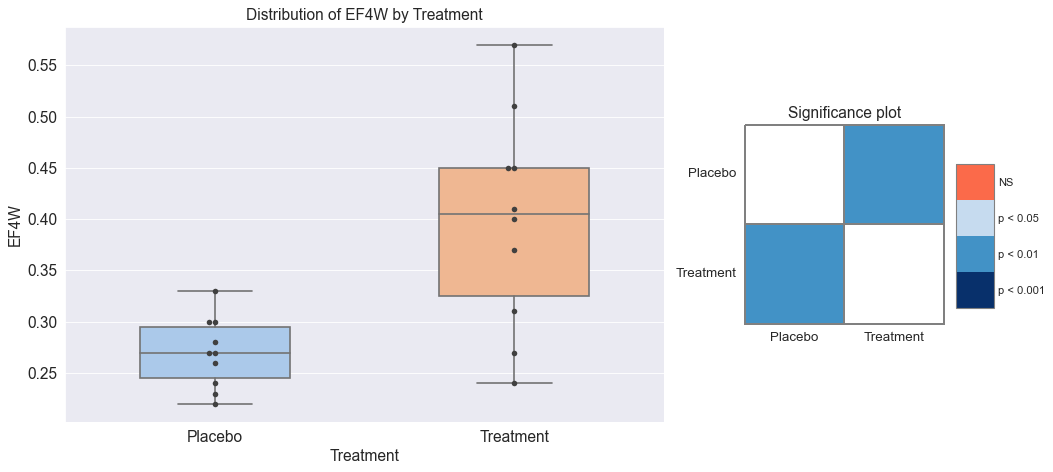

In [21]:
boxplot_with_significance_plot('Treatment', 'EF4W', df_box, 'EF4W', p_adjust='holm')

   Treatment  EFPre   EF2W   EF4W
0    Placebo  0.267  0.276  0.270
1  Treatment  0.250  0.321  0.398
EF2W t-statistic: -1.645, p-value: 0.11727
EF4W t-statistic: -3.692, p-value: 0.00167


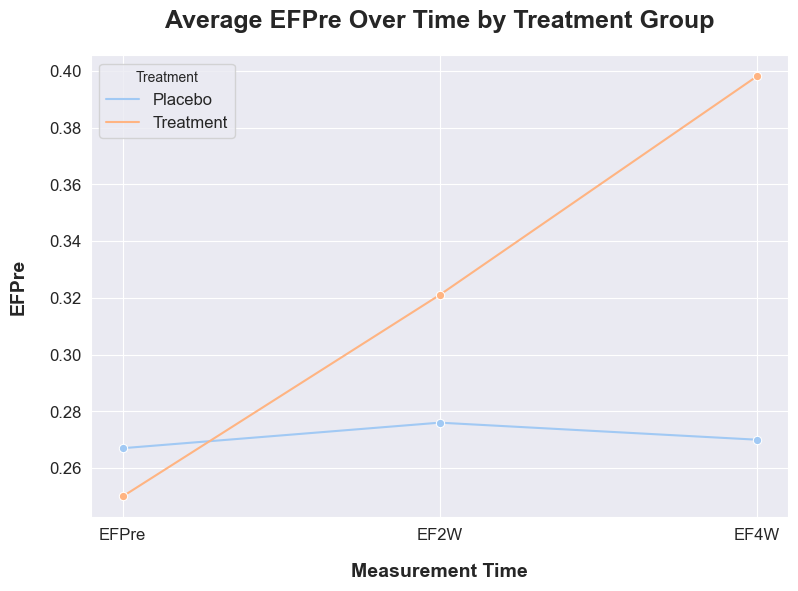

In [22]:
plot_measurements_over_time(df, ['EFPre', 'EF2W', 'EF4W'])

In [23]:
df.columns

Index(['PatientID', 'Treatment', 'HRPre', 'HR2W', 'HR4W', 'HR18M',
       'mortality _treatement_period', 'Mortality18M', 'EFPre', 'EF2W', 'EF4W',
       'EF18M', 'QoLPre', 'QoL2W', 'QoL4W', 'QoL18M', 'AdjPreLVSize',
       'AdjLVSize2W', 'AdjLVSize4W', 'AdjLVSize18M'],
      dtype='object')

/var/folders/qm/qx46fb850rlbh6q98fgw87lw0000gn/T/ipykernel_54170/62544634.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


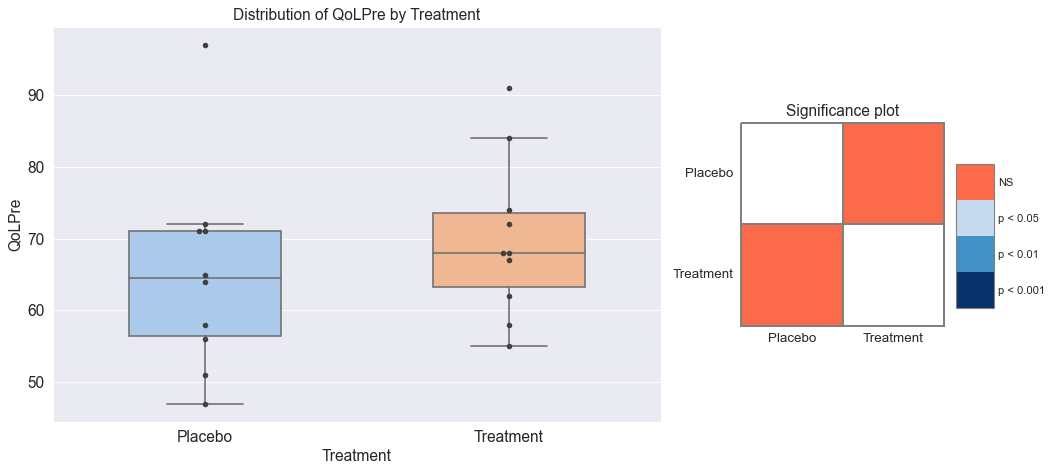

In [24]:
boxplot_with_significance_plot('Treatment', 'QoLPre', df_box, 'QoLPre', p_adjust='holm')

/var/folders/qm/qx46fb850rlbh6q98fgw87lw0000gn/T/ipykernel_54170/62544634.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


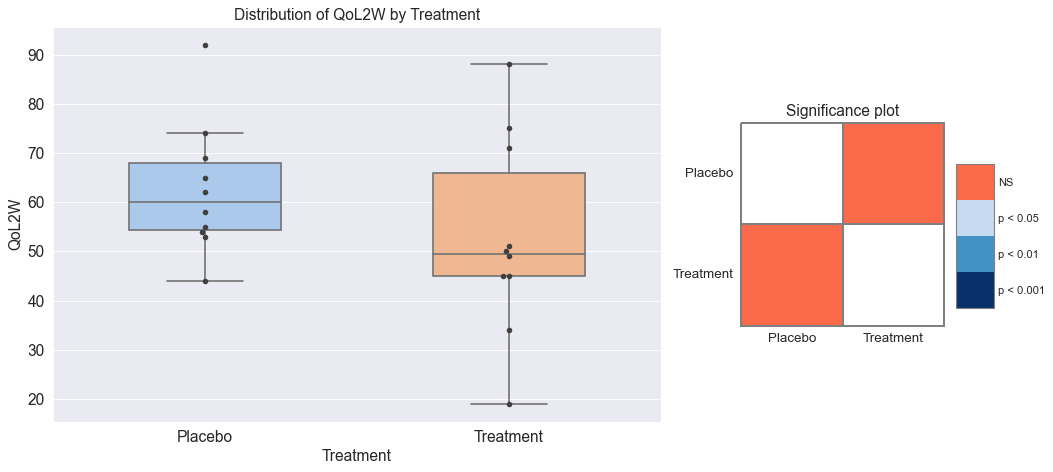

In [25]:
boxplot_with_significance_plot('Treatment', 'QoL2W', df_box, 'QoL2W', p_adjust='holm')

/var/folders/qm/qx46fb850rlbh6q98fgw87lw0000gn/T/ipykernel_54170/62544634.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


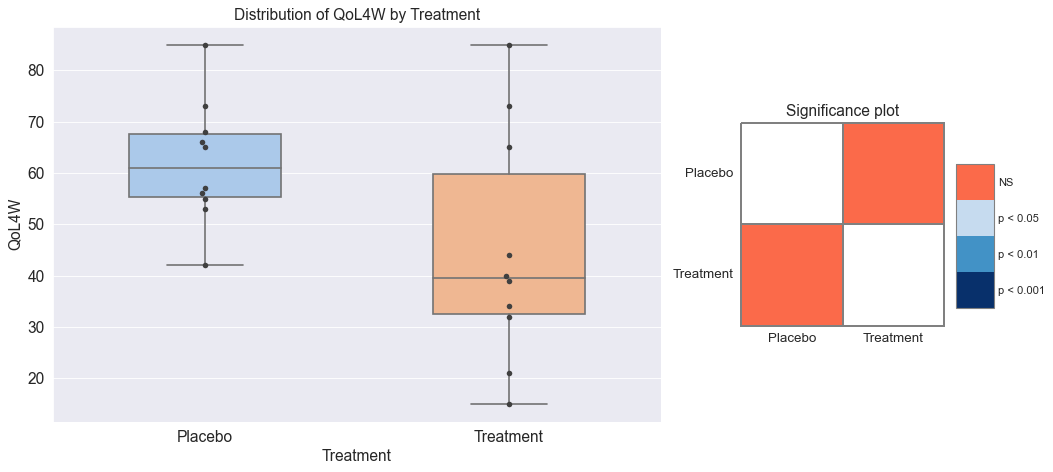

In [26]:
boxplot_with_significance_plot('Treatment', 'QoL4W', df_box, 'QoL4W', p_adjust='holm')

   Treatment  QoLPre  QoL2W  QoL4W
0    Placebo    65.2   62.6   62.0
1  Treatment    69.9   52.7   44.8
QoL2W t-statistic: 1.285, p-value: 0.21494
QoL4W t-statistic: 2.122, p-value: 0.04798


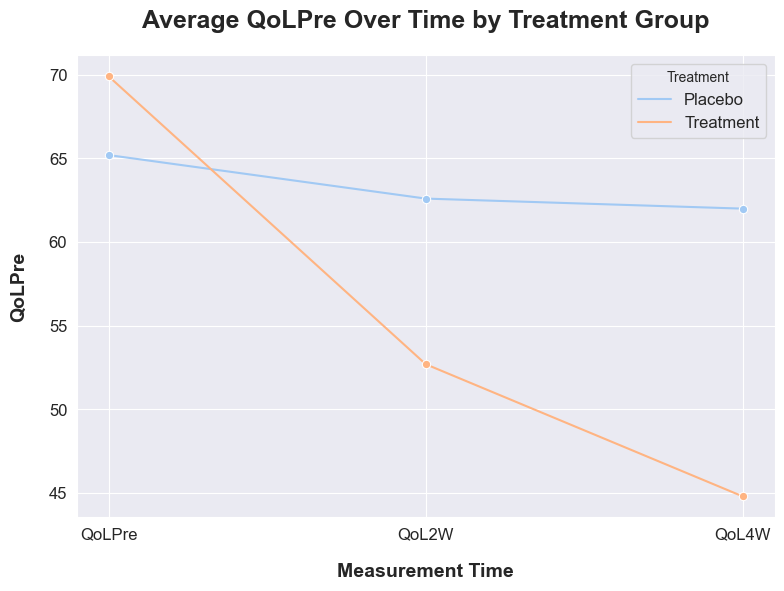

In [27]:
plot_measurements_over_time(df, ['QoLPre', 'QoL2W', 'QoL4W'])

## 3D Plots

#### 3D plots are a useful tool for visualizing and analyzing multidimensional data. In this case, we have represented six variables, including heart rate, ejection fraction, and left ventricular size, as the three axes in a 3D plot. The additional variables of treatment group, quality of life, and mortality are indicated by the color, size, and shape of the markers in the plot. By using a 3D plot, we are able to visualize how these six variables relate to each other in a single plot, allowing for easier identification of patterns and relationships between the variables. 


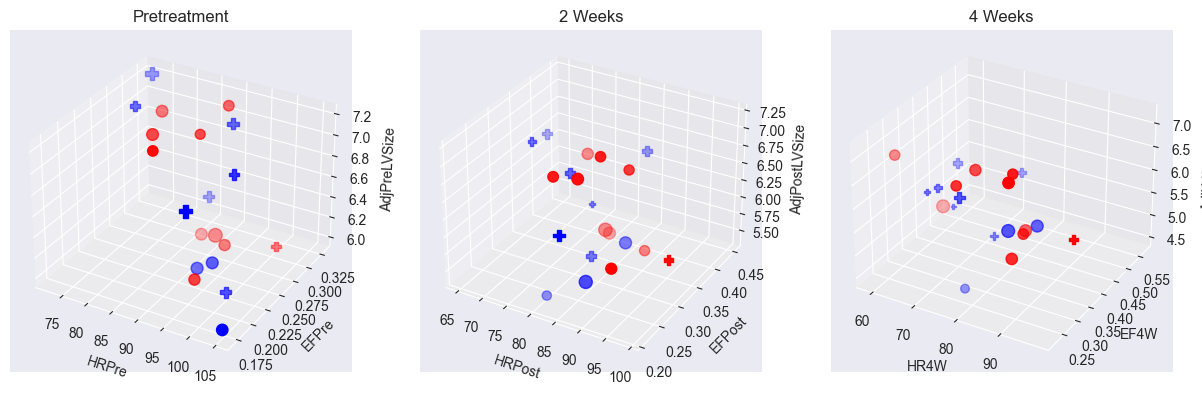

In [28]:
fig, axs = plt.subplots(1, 3, figsize=(15,5), subplot_kw={'projection': '3d'})

x = df['HRPre']
y = df['EFPre']
z = df['AdjPreLVSize']
c = np.where(df['Treatment']==1,'b','r')
s = df['QoLPre']
marker = df['Mortality18M']
for m in np.unique(marker):
    axs[0].scatter(x[marker==m], y[marker==m], z[marker==m], c=c[marker==m], s=s[marker==m], marker = 'o' if m==0 else 'P')


axs[0].set_xlabel('HRPre')
axs[0].set_ylabel('EFPre')
axs[0].set_zlabel('AdjPreLVSize')
axs[0].set_title('Pretreatment')

x = df['HR2W']
y = df['EF2W']
z = df['AdjLVSize2W']
c = np.where(df['Treatment']==1,'b','r')
s = df['QoL2W']
marker = df['Mortality18M']
for m in np.unique(marker):
    axs[1].scatter(x[marker==m], y[marker==m], z[marker==m], c=c[marker==m], s=s[marker==m], marker = 'o' if m==0 else 'P')


axs[1].set_xlabel('HRPost')
axs[1].set_ylabel('EFPost')
axs[1].set_zlabel('AdjPostLVSize')
axs[1].set_title('2 Weeks')

x = df['HR4W']
y = df['EF4W']
z = df['AdjLVSize4W']
c = np.where(df['Treatment']==1,'b','r')
s = df['QoL4W']
marker = df['Mortality18M']
for m in np.unique(marker):
    axs[2].scatter(x[marker==m], y[marker==m], z[marker==m], c=c[marker==m], s=s[marker==m], marker = 'o' if m==0 else 'P')

axs[2].set_xlabel('HR4W')
axs[2].set_ylabel('EF4W')
axs[2].set_zlabel('AdjLVSize4W')
axs[2].set_title('4 Weeks')

plt.show()

## Adding Hyperplanes

#### Adding regression hyperplanes to a 3D graph is useful because it allows us to visualize the relationship between multiple predictors and a binary outcome variable in a more comprehensive way. By including a hyperplane that shows the predicted probability of the binary outcome, we can see how the combination of the three predictors relates to the likelihood of a particular outcome. This provides us with a more nuanced understanding of the relationship between the predictors and the outcome, compared to simply looking at the bivariate relationships between each predictor and the outcome separately. Additionally, by using a 3D graph to display the hyperplanes, we can see the relationships between the predictors and the outcome from multiple angles, which can provide a more complete picture of the relationship between the variables.

/Users/nick/opt/anaconda3/envs/Torch_SB2/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- EF4W
Feature names seen at fit time, yet now missing:
- EF2W

  warnings.warn(message, FutureWarning)


Text(0.5, 0.92, 'Treatment vs Mortality18M')

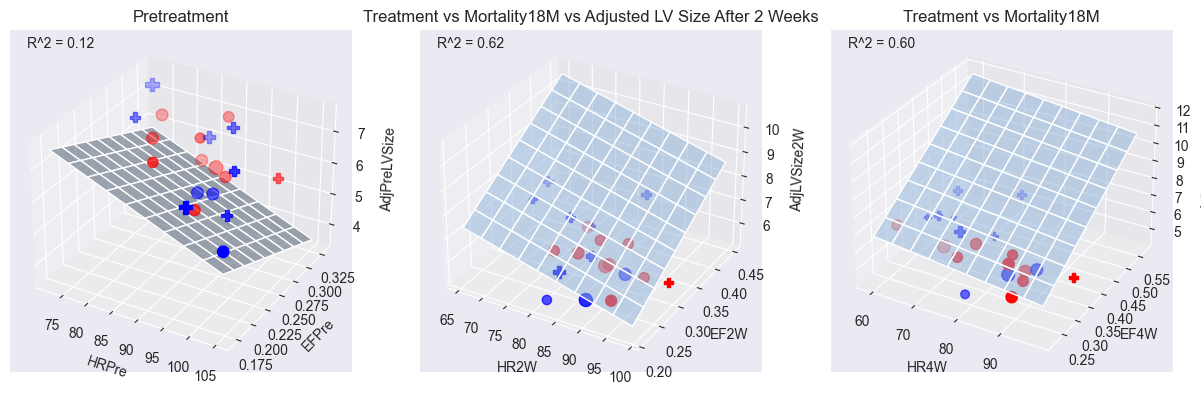

In [31]:
fig, axs = plt.subplots(1, 3, figsize=(15,5), subplot_kw={'projection': '3d'})

x = df['HRPre']
y = df['EFPre']
z = df['AdjPreLVSize']
c = np.where(df['Treatment']==1,'b','r')
s = df['QoLPre']
marker = df['Mortality18M']
for m in np.unique(marker):
    axs[0].scatter(x[marker==m], y[marker==m], z[marker==m], c=c[marker==m], s=s[marker==m], marker = 'o' if m==0 else 'P')

# Add a regression plane
model = LinearRegression()
model.fit(df[['HRPre', 'EFPre', 'AdjPreLVSize']], marker)
coef = model.coef_
intercept = model.intercept_

xx, yy = np.meshgrid(np.linspace(x.min(), x.max(), 10), np.linspace(y.min(), y.max(), 10))
zz = -(coef[0] * xx + coef[1] * yy + intercept) / coef[2]
axs[0].plot_surface(xx, yy, zz, alpha=0.5)

# Add R-squared value to the plot
r_squared = model.score(df[['HRPre', 'EFPre', 'AdjPreLVSize']], marker)
axs[0].text2D(0.05, 0.95, f'R^2 = {r_squared:.2f}', transform=axs[0].transAxes)

axs[0].set_xlabel('HRPre')
axs[0].set_ylabel('EFPre')
axs[0].set_zlabel('AdjPreLVSize')
axs[0].set_title('Pretreatment')

x = df['HR2W']
y = df['EF2W']
z = df['AdjLVSize2W']
c = np.where(df['Treatment']==1,'b','r')
s = df['QoL2W']
marker = df['Mortality18M']
for m in np.unique(marker):
    axs[1].scatter(x[marker==m], y[marker==m], z[marker==m], c=c[marker==m], s=s[marker==m], marker = 'o' if m==0 else 'P')

# regression plane for the second subplot
model = LinearRegression()
model.fit(df[['HR2W', 'EF2W', 'AdjLVSize2W']], marker)
coef = model.coef_
intercept = model.intercept_

xx, yy = np.meshgrid(np.linspace(x.min(), x.max(), 10), np.linspace(y.min(), y.max(), 10))
zz = -(coef[0] * xx + coef[1] * yy + intercept) / coef[2]
axs[1].plot_surface(xx, yy, zz, alpha=0.5)

# Add R-squared value to the plot
r_squared = model.score(df[['HR2W', 'EF2W', 'AdjLVSize2W']], marker)
axs[1].text2D(0.05, 0.95, f'R^2 = {r_squared:.2f}', transform=axs[1].transAxes)


axs[1].set_xlabel('HR2W')
axs[1].set_ylabel('EF2W')
axs[1].set_zlabel('AdjLVSize2W')
axs[1].set_title('Treatment vs Mortality18M vs Adjusted LV Size After 2 Weeks')

x = df['HR4W']
y = df['EF4W']
z = df['AdjLVSize4W']
c = np.where(df['Treatment']==1,'b','r')
s = df['QoL4W']
marker = df['Mortality18M']
for m in np.unique(marker):
    axs[2].scatter(x[marker==m], y[marker==m], z[marker==m], c=c[marker==m], s=s[marker==m], marker = 'o' if m==0 else 'P')

# Add a regression plane
model = LinearRegression()
model.fit(df[['HR4W', 'EF2W', 'AdjLVSize4W']], marker)
coef = model.coef_
intercept = model.intercept_

xx, yy = np.meshgrid(np.linspace(x.min(), x.max(), 10), np.linspace(y.min(), y.max(), 10))
zz = -(coef[0] * xx + coef[1] * yy + intercept) / coef[2]
axs[2].plot_surface(xx, yy, zz, alpha=0.5)

# Add R-squared value to the plot
r_squared = model.score(df[['HR4W', 'EF4W', 'AdjLVSize4W']], marker)
axs[2].text2D(0.05, 0.95, f'R^2 = {r_squared:.2f}', transform=axs[2].transAxes)

axs[2].set_xlabel('HR4W')
axs[2].set_ylabel('EF4W')
axs[2].set_zlabel('AdjLVSize4W')
axs[2].set_title('Treatment vs Mortality18M')

/Users/nick/opt/anaconda3/envs/Torch_SB2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/nick/opt/anaconda3/envs/Torch_SB2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/nick/opt/anaconda3/envs/Torch_SB2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


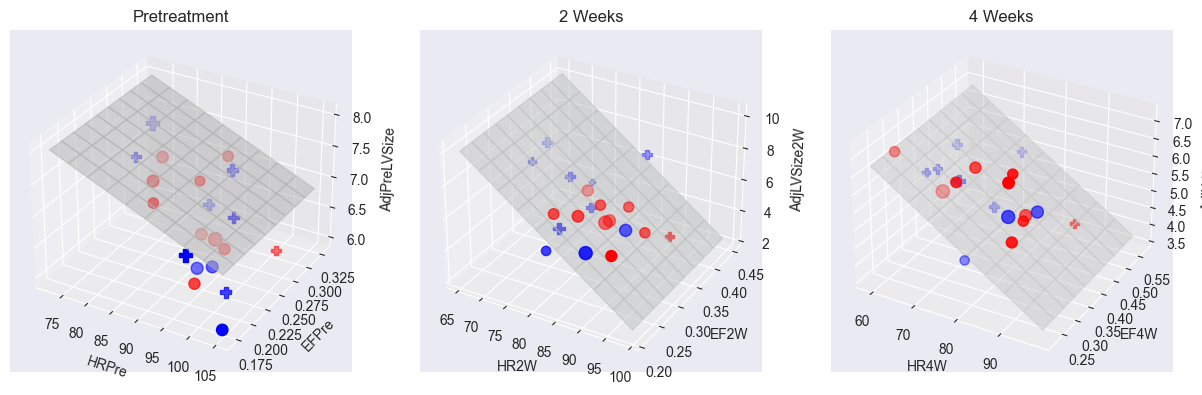

In [32]:
# Create 3D figure with subplots
fig, axs = plt.subplots(1, 3, figsize=(15,5), subplot_kw={'projection': '3d'})

# Plot the first subplot
x = df['HRPre']
y = df['EFPre']
z = df['AdjPreLVSize']
c = np.where(df['Treatment']==1,'b','r')
s = df['QoLPre']
marker = df['Mortality18M']
for m in np.unique(marker):
    axs[0].scatter(x[marker==m], y[marker==m], z[marker==m], c=c[marker==m], s=s[marker==m], marker = 'o' if m==0 else 'P')

# Add a regression plane to the first subplot
# fit logistic regression model
model = LogisticRegression(fit_intercept=True)
model.fit(df[['HRPre', 'EFPre', 'AdjPreLVSize']], marker)

# create meshgrid for surface plot
xx, yy = np.meshgrid(np.linspace(x.min(), x.max(), 10), np.linspace(y.min(), y.max(), 10))
zz = -(model.intercept_ + model.coef_[0][0] * xx + model.coef_[0][1] * yy) / model.coef_[0][2]
probas = model.predict_proba(np.column_stack((xx.ravel(), yy.ravel(), zz.ravel())))
probas = probas[:, 1].reshape(xx.shape)

# add surface plot to subplot
axs[0].plot_surface(xx, yy, zz, alpha=0.5, facecolors=plt.cm.RdBu(probas))

# Set labels and title for the first subplot
axs[0].set_xlabel('HRPre')
axs[0].set_ylabel('EFPre')
axs[0].set_zlabel('AdjPreLVSize')
axs[0].set_title('Pretreatment')

# Plot the second subplot
x = df['HR2W']
y = df['EF2W']
z = df['AdjLVSize2W']
c = np.where(df['Treatment']==1,'b','r')
s = df['QoL2W']
marker = df['Mortality18M']
for m in np.unique(marker):
    axs[1].scatter(x[marker==m], y[marker==m], z[marker==m], c=c[marker==m], s=s[marker==m], marker = 'o' if m==0 else 'P')


# fit logistic regression model
model = LogisticRegression(fit_intercept=True)
model.fit(df[['HR2W', 'EF2W', 'AdjLVSize2W']], marker)

# create meshgrid for surface plot
xx, yy = np.meshgrid(np.linspace(x.min(), x.max(), 10), np.linspace(y.min(), y.max(), 10))
zz = -(model.intercept_ + model.coef_[0][0] * xx + model.coef_[0][1] * yy) / model.coef_[0][2]
probas = model.predict_proba(np.column_stack((xx.ravel(), yy.ravel(), zz.ravel())))
probas = probas[:, 1].reshape(xx.shape)

# add surface plot to subplot
axs[1].plot_surface(xx, yy, zz, alpha=0.5, facecolors=plt.cm.RdBu(probas))


# Set labels and title for the second subplot
axs[1].set_xlabel('HR2W')
axs[1].set_ylabel('EF2W')
axs[1].set_zlabel('AdjLVSize2W')
axs[1].set_title('2 Weeks')

# Plot the third subplot
x = df['HR4W']
y = df['EF4W']
z = df['AdjLVSize4W']
c = np.where(df['Treatment']==1,'b','r')
s = df['QoL2W']
marker = df['Mortality18M']
for m in np.unique(marker):
    axs[2].scatter(x[marker==m], y[marker==m], z[marker==m], c=c[marker==m], s=s[marker==m], marker = 'o' if m==0 else 'P')

# fit logistic regression model
model = LogisticRegression(fit_intercept=True)
model.fit(df[['HR4W', 'EF4W', 'AdjLVSize4W']], marker)

# create meshgrid for surface plot
xx, yy = np.meshgrid(np.linspace(x.min(), x.max(), 10), np.linspace(y.min(), y.max(), 10))
zz = -(model.intercept_ + model.coef_[0][0] * xx + model.coef_[0][1] * yy) / model.coef_[0][2]
probas = model.predict_proba(np.column_stack((xx.ravel(), yy.ravel(), zz.ravel())))
probas = probas[:, 1].reshape(xx.shape)

# add surface plot to subplot
axs[2].plot_surface(xx, yy, zz, alpha=0.5, facecolors=plt.cm.RdBu(probas))

axs[2].set_xlabel('HR4W')
axs[2].set_ylabel('EF4W')
axs[2].set_zlabel('AdjLVSize4W')
axs[2].set_title('4 Weeks')

plt.show()


## Change in metrics over time 

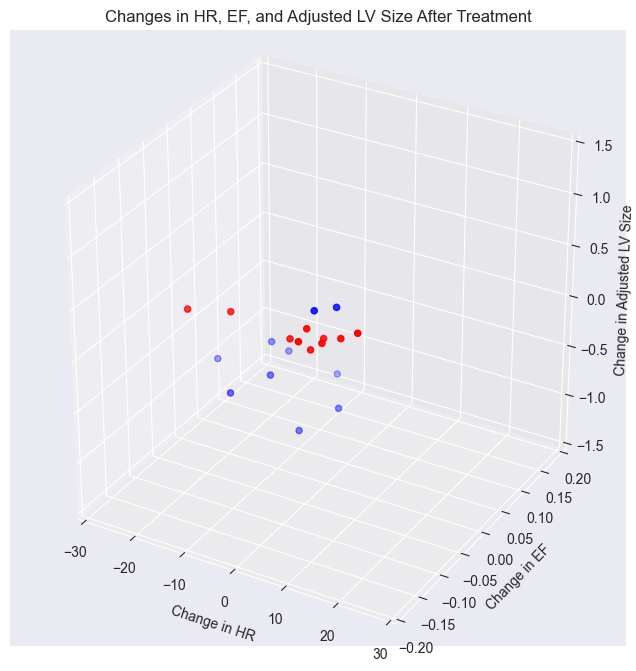

In [33]:
# set axes variables
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Compute the difference between post-treatment and pre-treatment values
dx = df['HR4W'] - df['HRPre']
dy = df['EF4W'] - df['EFPre']
dz = df['AdjLVSize4W'] - df['AdjPreLVSize']

# look into percentage difference.

# Color the points based on treatment
colors = np.where(df['Treatment'] == 1, 'blue', 'red')

# Create the scatter plot
ax.scatter(dx, dy, dz, c=colors, marker='o')

# Set axis labels
ax.set_xlabel('Change in HR')
ax.set_ylabel('Change in EF')
ax.set_zlabel('Change in Adjusted LV Size')

# Set axis limits
ax.set_xlim(-30, 30)
ax.set_ylim(-.2, .2)
ax.set_zlim(-1.5, 1.5)

# Set the aspect ratio of the plot to be equal
ax.set_box_aspect([1, 1, 1])

# Add a title
ax.set_title('Changes in HR, EF, and Adjusted LV Size After Treatment')

plt.show()

## Patient Survival 

In [34]:
df.head(1)

,PatientID,Treatment,HRPre,HR2W,HR4W,HR18M,mortality _treatement_period,Mortality18M,EFPre,EF2W,EF4W,EF18M,QoLPre,QoL2W,QoL4W,QoL18M,AdjPreLVSize,AdjLVSize2W,AdjLVSize4W,AdjLVSize18M
0,1,0,82.0,85.0,89.0,Dead,1.0,0.0,0.25,0.25,0.24,Dead,72.0,69.0,68.0,Dead,7.1,7.0,7.2,7.1


In [35]:
df.columns

Index(['PatientID', 'Treatment', 'HRPre', 'HR2W', 'HR4W', 'HR18M',
       'mortality _treatement_period', 'Mortality18M', 'EFPre', 'EF2W', 'EF4W',
       'EF18M', 'QoLPre', 'QoL2W', 'QoL4W', 'QoL18M', 'AdjPreLVSize',
       'AdjLVSize2W', 'AdjLVSize4W', 'AdjLVSize18M'],
      dtype='object')

In [36]:
# Subset the data for placebo and treatment groups
placebo = df[df['Treatment'] == 0]
treatment = df[df['Treatment'] == 1]

# Calculate the survival rates for each group
placebo_survival = 1 - placebo['Mortality18M'].mean()
treatment_survival = 1 - treatment['Mortality18M'].mean()

# Print the survival rates
print(f"Placebo survival rate: {placebo_survival:.2%}")
print(f"Treatment survival rate: {treatment_survival:.2%}")

Placebo survival rate: 90.00%
Treatment survival rate: 30.00%


In [37]:
import scipy.stats as stats

# Split the data into treatment and placebo groups
treatment_data = df[df['Treatment'] == 1]['Mortality18M']
placebo_data = df[df['Treatment'] == 0]['Mortality18M']

# Perform two-sample t-test
t_stat, p_value = stats.ttest_ind(treatment_data, placebo_data)

# Print the results
print(f"T-Statistic: {t_stat:.4f}")
print(f"P-Value: {p_value:.4f}")


T-Statistic: 3.2863
P-Value: 0.0041


In [38]:
# Select the relevant columns for the analysis
ef_cols = ['EFPre', 'EF4W', 'Treatment']

# Filter the data by treatment group
treatment_df = df[df['Treatment'] == 1]
placebo_df = df[df['Treatment'] == 0]

# Calculate the average change in EF for each group
treatment_ef_change = treatment_df['EF4W'].mean() - treatment_df['EFPre'].mean()
placebo_ef_change = placebo_df['EF4W'].mean() - placebo_df['EFPre'].mean()

# Print the results
print(f"Average change in EF for treatment group: {treatment_ef_change:.2f}")
print(f"Average change in EF for placebo group: {placebo_ef_change:.2f}")


Average change in EF for treatment group: 0.15
Average change in EF for placebo group: 0.00
